# Machine Learning: Classification Predict Team 4

## Problem Statement:

### Global Warming Sentiment Analysis using Twitter Data

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

## Objective:
This notebook is an attempt to solve the problem of text classification on twitter text data to predict whether a person believes in climate change or not. The data has been downloaded from Kaggle.
https://www.kaggle.com/c/climate-change-belief-analysis/data

## Importing libraries and datasets

*   Train dataset - Training the model will be done on this dataset.
*   Test dataset - The model will be tested on this dataset 
*   Sample solution - Kaggle completion model solution



In [ ]:
#Deploying the model
from comet_ml import Experiment

In [ ]:
# Api key
experiment = Experiment(api_key="NMdrE2Fvv00bzfhwE99pCjGSq",
                        project_name="team-4-climate-change", workspace="primmk")

In [1]:
#Standard Imports
import numpy as np
import pandas as pd
import re

#Visualisations 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#DATA CLEANING
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
from textblob import Word

#MODELLING
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Train dataset

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


### Test dataset

In [3]:
test_df = pd.read_csv('test.csv')
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


### Sample solution

In [4]:
ss = pd.read_csv('sample_submission.csv')
ss.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


# 1. Data Cleaning

**Dealing with null values**

In [5]:
train_df.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [6]:
test_df.isnull().sum()

message    0
tweetid    0
dtype: int64

**Observations**

*   Both the test and train dataframes do not contain any null values.



**Value counts**

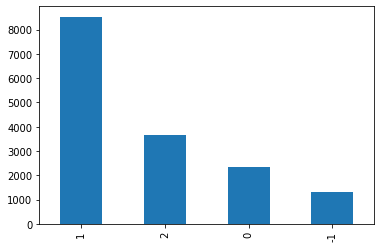

In [7]:
train_df['sentiment'].value_counts().plot.bar()

In [8]:
train_df['tweetid'].nunique()

15819

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


**Observations**

*   There are 15 819 tweets, all tweete have a unique tweet ID.
*   The sentiment and tweet id columns are of int64 data type and the message column is an object datatype.
*   The classes are imbalanced, with the tweeters believing in climate change (pro tweets) having the most count, and the tweeters who do not believe in climate change (anti tweets) having the least count.
*   The imbalance of classes may train our model to only be good at detecting only the pro tweets, therefore having an inaccurate accuracy.
*   The classes imbalance is a ratio of 4:1, we are going to tune the model or deploy a model that can work to counteract the imbalancing of classes.








In [43]:
dataframe = train_df.copy()
dataframe.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


**Combining train and test dataframes to prevent doing the same preprocessing steps twice**

In [44]:
df = dataframe.append(test_df, ignore_index=True)
df.head()

,sentiment,message,tweetid
0,1.0,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1.0,It's not like we lack evidence of anthropogeni...,126103
2,2.0,RT @RawStory: Researchers say we have three ye...,698562
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [ ]:
print('Dataset size:', df.shape)
print('Columns are:', df.columns)

# **Data Cleaning**

In [12]:
# function to remove twitter handles
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

In [45]:
# remove twitter handles (@user)
data=df.copy()
data['tidy_tweet'] = np.vectorize(remove_pattern)(data['message'], "@[\w]*")

In [46]:
data.head()

,sentiment,message,tweetid,tidy_tweet
0,1.0,PolySciMajor EPA chief doesn't think carbon di...,625221,PolySciMajor EPA chief doesn't think carbon di...
1,1.0,It's not like we lack evidence of anthropogeni...,126103,It's not like we lack evidence of anthropogeni...
2,2.0,RT @RawStory: Researchers say we have three ye...,698562,RT : Researchers say we have three years to ac...
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#TodayinMaker# WIRED : 2016 was a pivotal year...
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"RT : It's 2016, and a racist, sexist, climate ..."


In [47]:
# Removing short words
data['tidy_tweet'] = data['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [48]:
data.head()

,sentiment,message,tweetid,tidy_tweet
0,1.0,PolySciMajor EPA chief doesn't think carbon di...,625221,PolySciMajor chief doesn't think carbon dioxid...
1,1.0,It's not like we lack evidence of anthropogeni...,126103,It's like lack evidence anthropogenic global w...
2,2.0,RT @RawStory: Researchers say we have three ye...,698562,Researchers have three years climate change be...
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#TodayinMaker# WIRED 2016 pivotal year climate...
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"It's 2016, racist, sexist, climate change deny..."


In [49]:
# Removing https/http links
data['tidy_tweet'] = data['tidy_tweet'].apply(lambda x: re.sub('http[s]?://\S+', '', x))
data.head()

,sentiment,message,tweetid,tidy_tweet
0,1.0,PolySciMajor EPA chief doesn't think carbon di...,625221,PolySciMajor chief doesn't think carbon dioxid...
1,1.0,It's not like we lack evidence of anthropogeni...,126103,It's like lack evidence anthropogenic global w...
2,2.0,RT @RawStory: Researchers say we have three ye...,698562,Researchers have three years climate change be...
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#TodayinMaker# WIRED 2016 pivotal year climate...
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"It's 2016, racist, sexist, climate change deny..."


In [50]:
# Removing numbers
data['tidy_tweet'] = data['tidy_tweet'].apply(lambda x: re.sub('\d+','',x.lower()))
data.head()

,sentiment,message,tweetid,tidy_tweet
0,1.0,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor chief doesn't think carbon dioxid...
1,1.0,It's not like we lack evidence of anthropogeni...,126103,it's like lack evidence anthropogenic global w...
2,2.0,RT @RawStory: Researchers say we have three ye...,698562,researchers have three years climate change be...
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#todayinmaker# wired pivotal year climate cha...
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"it's , racist, sexist, climate change denying ..."


In [51]:
# remove special characters, numbers, punctuations except for hashtags
data['tidy_tweet'] = data['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
data.head()

,sentiment,message,tweetid,tidy_tweet
0,1.0,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor chief doesn t think carbon dioxid...
1,1.0,It's not like we lack evidence of anthropogeni...,126103,it s like lack evidence anthropogenic global w...
2,2.0,RT @RawStory: Researchers say we have three ye...,698562,researchers have three years climate change be...
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#todayinmaker# wired pivotal year climate cha...
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,it s racist sexist climate change denying ...


**Tokenizing text**

In [52]:
tokenize_tweet = data['tidy_tweet'].apply(lambda x: x.split())
tokenize_tweet.head()

0    [polyscimajor, chief, doesn, t, think, carbon,...
1    [it, s, like, lack, evidence, anthropogenic, g...
2    [researchers, have, three, years, climate, cha...
3    [#todayinmaker#, wired, pivotal, year, climate...
4    [it, s, racist, sexist, climate, change, denyi...
Name: tidy_tweet, dtype: object

**Removing stop words**

In [54]:
# Load stop words
stop_words = stopwords.words('english')

# Show stop words
stop_words[:5]

['i', 'me', 'my', 'myself', 'we']

In [55]:
# Remove stop words
tokenize_tweet2 = []
for i in range(len(tokenize_tweet)):

    row = []
    for tweet in tokenize_tweet[i]:
        if tweet not in stop_words:
            row.append(tweet)

    tokenize_tweet2.append(row)
            

In [56]:
# Stitch words back together and into dataframe
for i in range(len(tokenize_tweet2)):
    tokenize_tweet2[i] = ' '.join(tokenize_tweet2[i])

data['tidy_tweet'] = tokenize_tweet2

In [57]:
data.head()

,sentiment,message,tweetid,tidy_tweet
0,1.0,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor chief think carbon dioxide main c...
1,1.0,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming
2,2.0,RT @RawStory: Researchers say we have three ye...,698562,researchers three years climate change late
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#todayinmaker# wired pivotal year climate change
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,racist sexist climate change denying bigot lea...


In [58]:
# Removing news articles from the dataframe
data=data[data.sentiment != 2]
data.head()

,sentiment,message,tweetid,tidy_tweet
0,1.0,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor chief think carbon dioxide main c...
1,1.0,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#todayinmaker# wired pivotal year climate change
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,racist sexist climate change denying bigot lea...
5,1.0,Worth a read whether you do or don't believe i...,425577,worth read whether believe climate change


# Data Visualization/Exploratory Data Analysis

**WordCloud Visualization(s)**

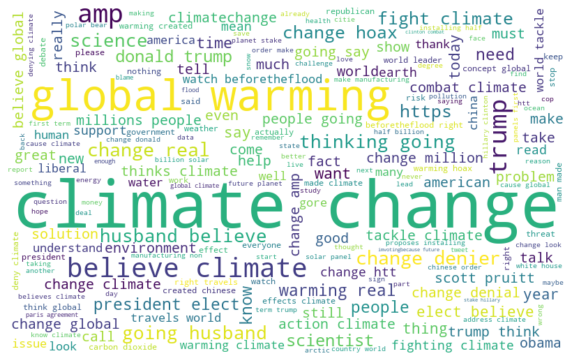

In [59]:
#Wordcloud for most frequent words in all the tweets
all_words = ' '.join([text for text in data['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,background_color="white").generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

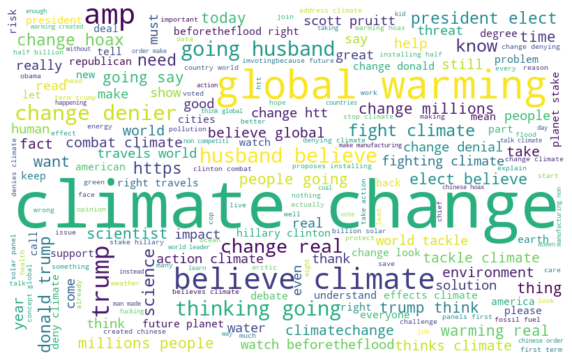

In [60]:
#Wordcloud for most frequent words in pro climate change tweets
pro_tweets =' '.join([text for text in data['tidy_tweet'][data['sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color="white").generate(pro_tweets)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

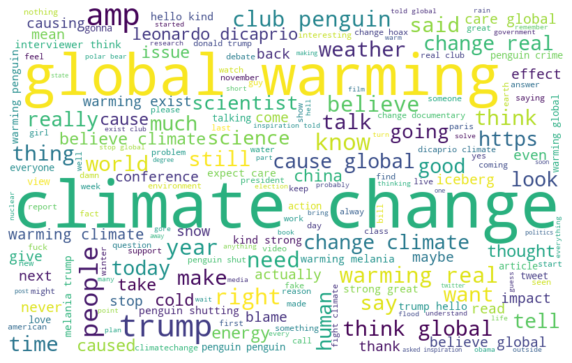

In [61]:
#Wordcloud for most frequent words in neutral tweets
neutral_tweets =' '.join([text for text in data['tidy_tweet'][data['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color="white").generate(neutral_tweets)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

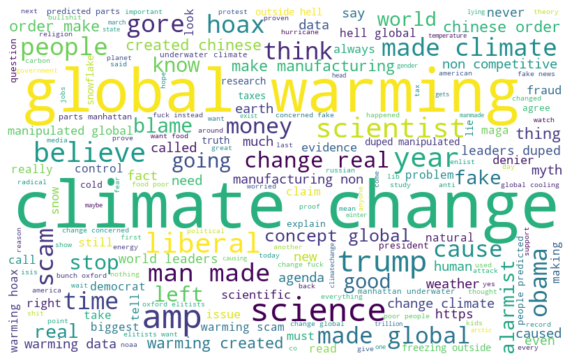

In [62]:
#Wordcloud for most frequent words in anti climate change tweets
anti_tweets =' '.join([text for text in data['tidy_tweet'][data['sentiment'] == -1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color="white").generate(anti_tweets)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Observations**

*   Climate change seems to be the most frequently used word in all the tweet classes.
*   There is an overlap in frequest words among the classes, however, not much distinction can be drawn from the wordcloud.
*   Since WordCloud does not show how frequently a word appears, we will create a frequent words dictionary with top 20 counts for much better information extrapolation.








In [63]:
#extracting tweets for each tweet class
anti_tweets =[text for text in data['tidy_tweet'][data['sentiment'] == -1]]
pro_tweets=[text for text in data['tidy_tweet'][data['sentiment'] == 1]]
neutral_tweets = [text for text in data['tidy_tweet'][data['sentiment'] == 0]]

In [64]:
#value counts: top 20 most appearing words for each tweet class 
anti_series=pd.Series(' '.join(anti_tweets).split()).value_counts()[:20]
pro_series=pd.Series(' '.join(pro_tweets).split()).value_counts()[:20]
neutral_series = pd.Series(' '.join(neutral_tweets).split()).value_counts()[:20]

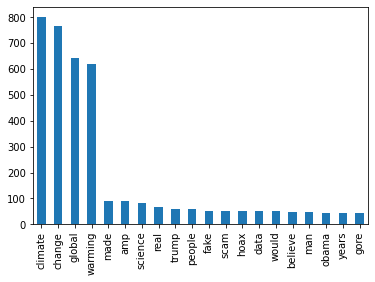

In [65]:
# top 20 most appearing words for the anti climate change class(sentiment=-1)
anti_series.plot.bar()

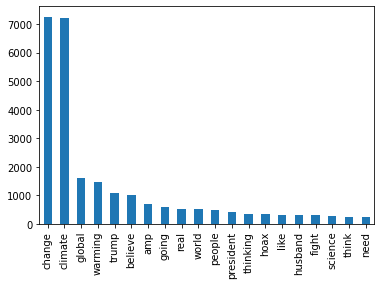

In [66]:
# top 20 most appearing words for the pro climate change class(sentiment=1)
pro_series.plot.bar()

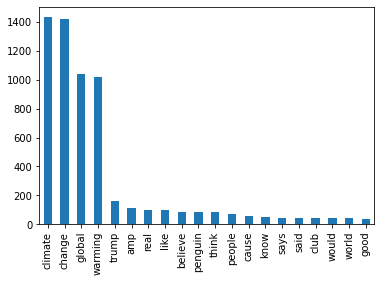

In [67]:
# top 20 most appearing words for the neutral climate change class(sentiment=0)
neutral_series.plot.bar()

**Observations**

*   There still is an overlap of frquently tweeted words btween the categories
*   We will investigate the hashtags assciated with each category, to see if there is any difference.



In [68]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [69]:
# extracting hashtags from pro climate change tweets

HT_pro = hashtag_extract(data['tidy_tweet'][data['sentiment'] == 1])

# extracting hashtags from anti climate change tweets
HT_anti = hashtag_extract(data['tidy_tweet'][data['sentiment'] == -1])

#extracting hashtags from neutral tweets
HT_neutral = hashtag_extract(data['tidy_tweet'][data['sentiment'] == 0])
# unnesting list
HT_pro = sum(HT_pro,[])
HT_anti = sum(HT_anti,[])
HT_neutral= sum(HT_neutral,[])

Pro Climate change Hashtags

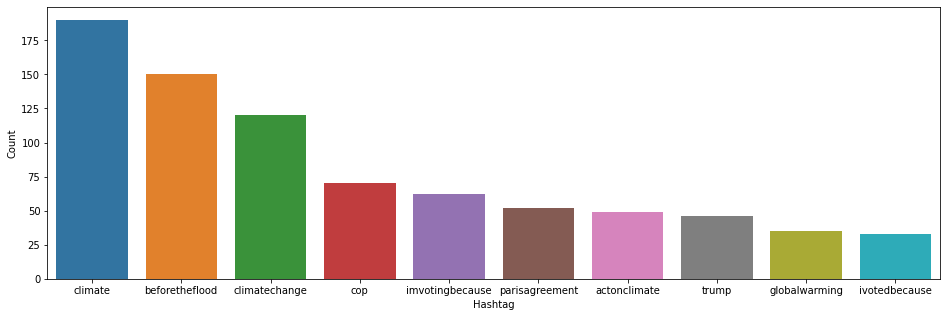

In [70]:
a = nltk.FreqDist(HT_pro)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

Anti Climate change Hashtags

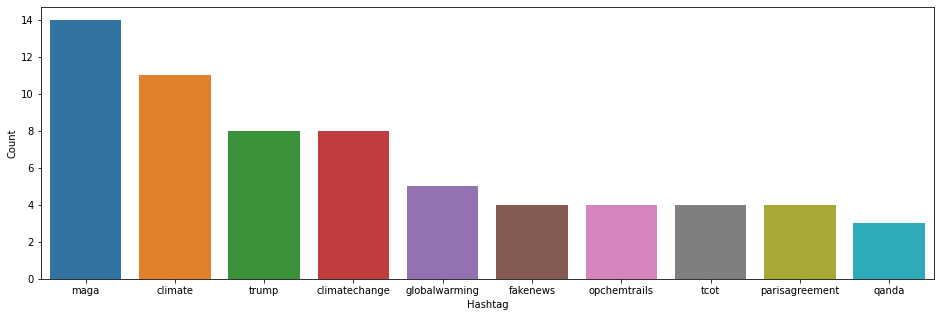

In [32]:
a = nltk.FreqDist(HT_anti)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

Neutral Hashtags

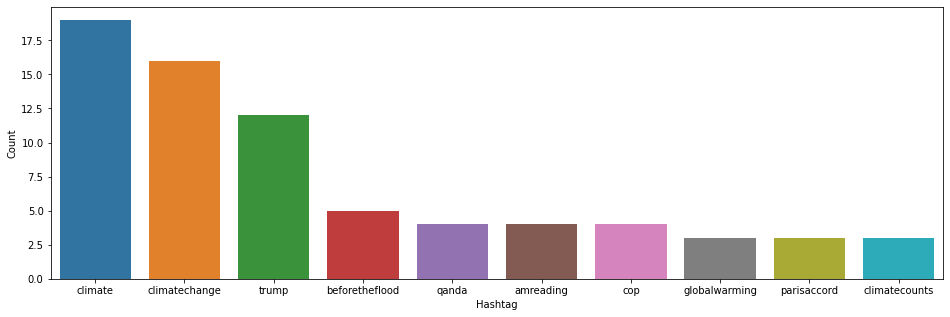

In [34]:
a = nltk.FreqDist(HT_neutral)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

**Observations**


*   Climate and change common for pro, anti and neutral tweets.
*  However, extracting hashtags does show a difference/distinction between the tweet classes. 
*   Pro climate change tweets have a high number of 'before the flood' hashtags which is for a documentary that is about climate change.
*   Anti climate change tweets are frequented by the 'fake news' hashtags, which is synonymous to disbelieving in a particular phenomenon.
*   We will keep the hashtags because they will help the model to learn better to differentiate between a pro tweet and an anti climate change tweet.







In [ ]:
#from nltk.stem.porter import *
#stemmer = PorterStemmer()

#tokenize_tweet = tokenize_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
#tokenize_tweet.head()

### 1.1 Vectorize

In [ ]:
#from sklearn.feature_extraction.text import CountVectorizer
#bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
#bow = bow_vectorizer.fit_transform(data['tidy_tweet'])

In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
#tfidf = tfidf_vectorizer.fit_transform(data['tidy_tweet'])

# 3. Model Training: Classification

### Fitting Model

In [ ]:
#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import f1_score

In [ ]:
#train_bow = bow[:15819,:]
#test_bow = bow[15819:,:]

In [ ]:
# splitting data into training and validation set
#xtrain_bow, xtest_bow, ytrain, ytest = train_test_split(train_bow, train_df['sentiment'], random_state=42, test_size=0.3)

In [ ]:
#from sklearn import svm
#clf_svm = svm.SVC(kernel='linear')

In [ ]:
#clf_svm.fit(xtrain_bow, ytrain)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#sentiment_pred = clf_svm.predict(xtest_bow)
#sentiment_pred

array([ 1,  1,  0, ..., -1,  0,  1])

In [ ]:
#sentiment_pred_int = sentiment_pred.astype(np.int)

#f1_score(ytest, sentiment_pred_int,average='macro')

0.5698971721766491

In [ ]:
#train_tfidf = tfidf[:15819,:]
#test_tfidf = tfidf[15819:,:]


In [ ]:
# splitting data into training and validation set
#xtrain_tfidf, xtest_tfidf, ytrain_tfidf, ytest_tfidf = train_test_split(train_tfidf, train_df['sentiment'], random_state=42, test_size=0.3)

In [ ]:
#clf_svm.fit(xtrain_tfidf, ytrain_tfidf)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#sentiment_pred_tfidf = clf_svm.predict(xtest_tfidf)
#sentiment_pred_tfidf

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
#sentiment_pred_tfidf_int = sentiment_pred.astype(np.int)

#f1_score(ytest_tfidf, sentiment_pred_tfidf_int,average='macro')

0.5698971721766491